## 1. Project Overview and Imports

In [52]:
# Import necessary libraries
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from collections import Counter
from sklearn.metrics import precision_recall_fscore_support
import warnings
import string
warnings.filterwarnings("ignore")

## 2. Load and Explore the Dataset

Dataset Shape:  (6335, 4)
First few rows of the dataset:
    Unnamed: 0                                              title  \
0        8476                       You Can Smell Hillary’s Fear   
1       10294  Watch The Exact Moment Paul Ryan Committed Pol...   
2        3608        Kerry to go to Paris in gesture of sympathy   
3       10142  Bernie supporters on Twitter erupt in anger ag...   
4         875   The Battle of New York: Why This Primary Matters   

                                                text label  
0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
2  U.S. Secretary of State John F. Kerry said Mon...  REAL  
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE  
4  It's primary day in New York and front-runners...  REAL  

Label distribution:
 label
REAL    3171
FAKE    3164
Name: count, dtype: int64


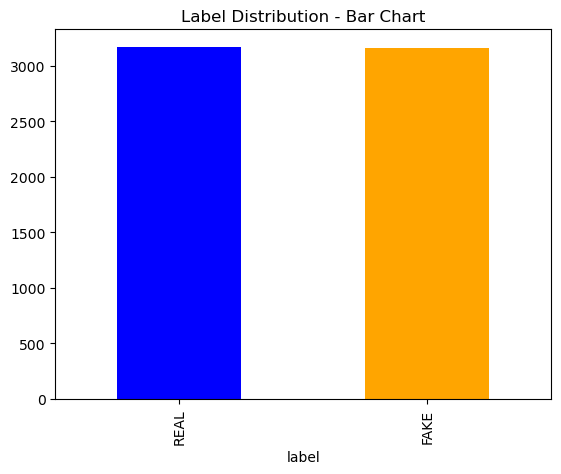

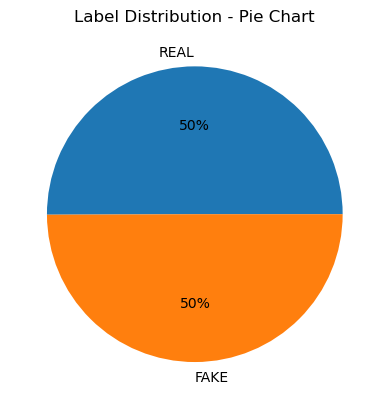

In [53]:
# Load dataset
df = pd.read_csv('content/news.csv')

# Display basic information
print("Dataset Shape: ", df.shape)
print("First few rows of the dataset:\n", df.head())

# Distribution of the target variable
count_class = pd.value_counts(df['label'], sort=True)
print("\nLabel distribution:\n", count_class)

# Plot label distribution (Bar and Pie chart)
count_class.plot(kind='bar', color=["blue", "orange"])
plt.title('Label Distribution - Bar Chart')
plt.show()

count_class.plot(kind='pie', autopct='%1.0f%%')
plt.title('Label Distribution - Pie Chart')
plt.ylabel('')
plt.show()

## 3. Word Frequency Analysis

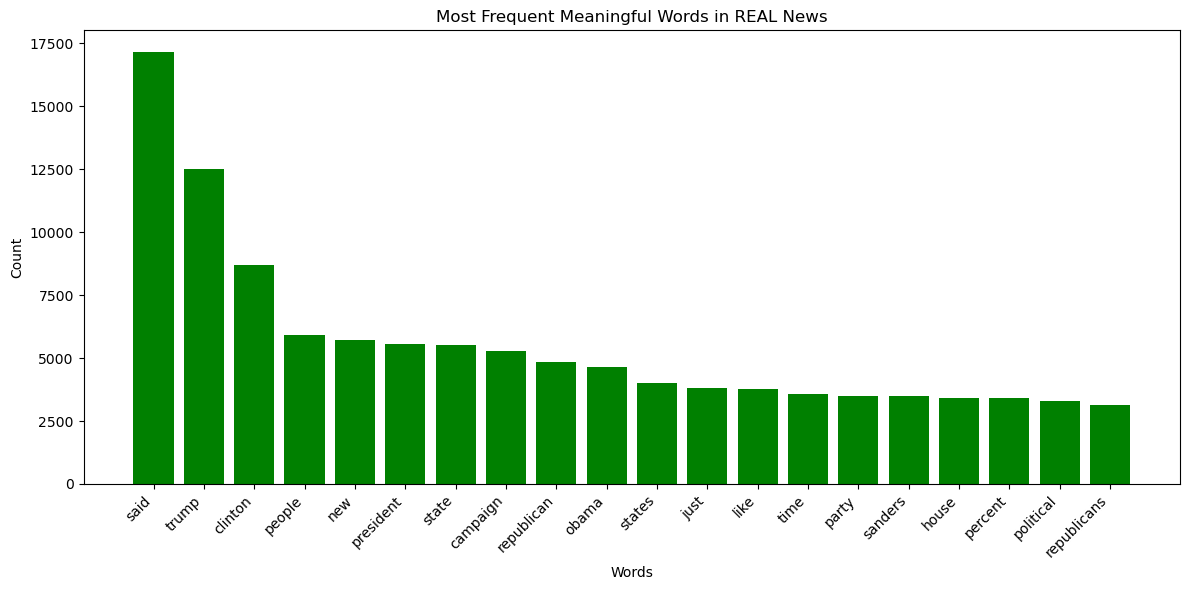

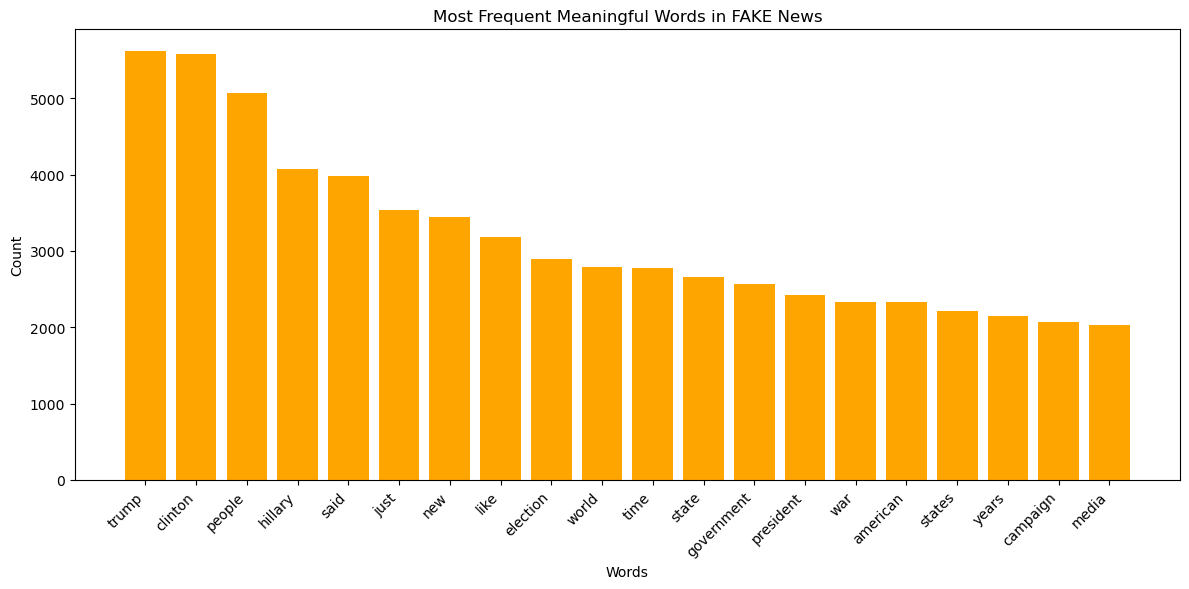

In [54]:
"""## 3. Word Frequency Analysis"""

def preprocess_text(text):
    """
    Preprocesses the input text by:
    - Converting to lowercase
    - Removing punctuation
    - Splitting into words based on whitespace
    - Removing stop words
    - Keeping only alphabetic words
    """
    if not isinstance(text, str):
        return []
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    
    # Split text into words based on whitespace
    words = text.split()
    
    # Remove stop words and non-alphabetic words
    meaningful_words = [
        word for word in words 
        if word not in ENGLISH_STOP_WORDS and word.isalpha()
    ]
    
    return meaningful_words

# Apply the preprocessing function to the 'text' column
df['processed_text'] = df['text'].apply(preprocess_text)

# Function to get the most common words for a given label
def get_most_common_words(df, label, top_n=20):
    """
    Returns the most common words for a given label.
    """
    # Filter the DataFrame by label
    filtered_text = df[df['label'] == label]['processed_text']
    
    # Flatten the list of lists into a single list of words
    all_words = list(itertools.chain.from_iterable(filtered_text))
    
    # Count word frequencies
    word_counts = Counter(all_words).most_common(top_n)
    
    return word_counts

# Get the most common words for REAL and FAKE news
count_real = get_most_common_words(df, 'REAL', top_n=20)
count_fake = get_most_common_words(df, 'FAKE', top_n=20)

# Convert word counts to DataFrame
df_real = pd.DataFrame(count_real, columns=["words in REAL", "count"])
df_fake = pd.DataFrame(count_fake, columns=["words in FAKE", "count"])

# Plot word frequencies for REAL news
plt.figure(figsize=(12, 6))
plt.bar(df_real["words in REAL"], df_real["count"], color='green')
plt.xticks(rotation=45, ha='right')
plt.title('Most Frequent Meaningful Words in REAL News')
plt.xlabel('Words')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Plot word frequencies for FAKE news
plt.figure(figsize=(12, 6))
plt.bar(df_fake["words in FAKE"], df_fake["count"], color='orange')
plt.xticks(rotation=45, ha='right')
plt.title('Most Frequent Meaningful Words in FAKE News')
plt.xlabel('Words')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## 4. Preprocess Data and Split Dataset

In [55]:
# Define features (X) and target (y)
X = df['text']
y = df['label']

# Split data into training and testing sets (33% test size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Print the size of each split
print(f"Training data size: {X_train.shape[0]}, Testing data size: {X_test.shape[0]}")

Training data size: 4244, Testing data size: 2091


## 5. TF-IDF Vectorization and Model Training

In [56]:
# Define the TF-IDF Vectorizer and LinearSVC Classifier in a pipeline
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.7)),
    ('clf', LinearSVC())
])

# Train the model on training data
text_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.7, stop_words='english')),
                ('clf', LinearSVC())])

## 6. Evaluate the Model

In [57]:
# Make predictions on the test set
y_pred = text_clf.predict(X_test)

# Calculate and display evaluation metrics
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


Confusion Matrix:
 [[1019   52]
 [  77  943]]

Classification Report:
               precision    recall  f1-score   support

        FAKE       0.93      0.95      0.94      1071
        REAL       0.95      0.92      0.94      1020

    accuracy                           0.94      2091
   macro avg       0.94      0.94      0.94      2091
weighted avg       0.94      0.94      0.94      2091

Accuracy: 93.83%


## 7. Implement Multiple Classifiers


Summary of Classifier Performance with Cross-Validation:
                    CV Accuracy Mean (%)  CV Accuracy Std (%)  \
LinearSVC                      92.530724             0.963718   
LogisticRegression             90.951730             1.268846   
MultinomialNB                  80.348384             1.716591   
SGDClassifier                  92.695569             0.962683   

                    CV Precision Mean (%)  CV Recall Mean (%)  \
LinearSVC                       92.607418           92.530724   
LogisticRegression              91.106940           90.951730   
MultinomialNB                   84.860507           80.348384   
SGDClassifier                   92.759189           92.695569   

                    CV F1-Score Mean (%)  Test Accuracy (%)  \
LinearSVC                      92.529428          93.256815   
LogisticRegression             90.947098          91.439503   
MultinomialNB                  79.611580          81.539933   
SGDClassifier                  92.6946

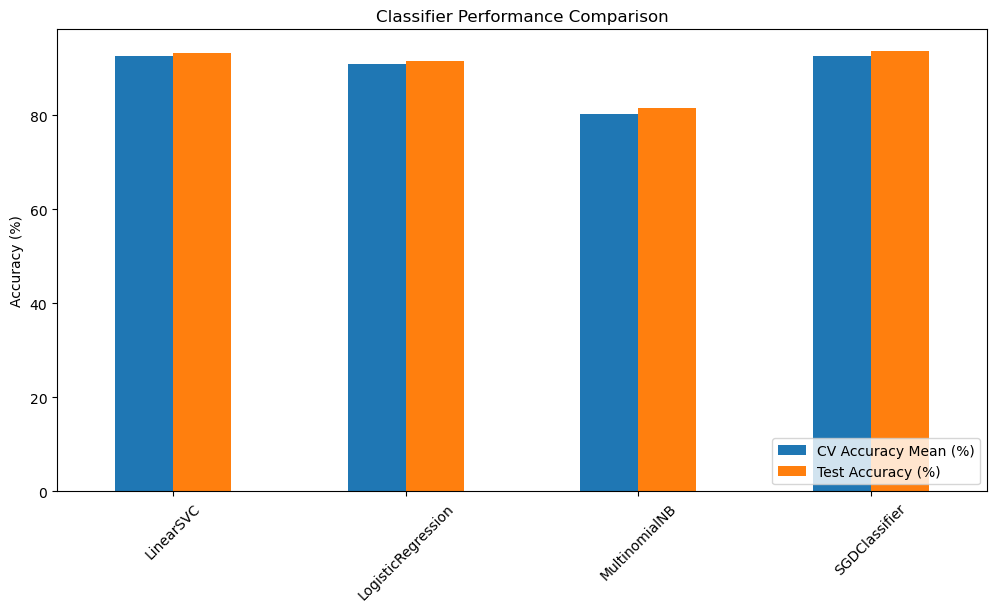

In [58]:
# Define a list of classifiers to compare, including Naive Bayes and SGDClassifier
classifiers = {
    'LinearSVC': LinearSVC(C=100,tol=0.1),
    'LogisticRegression': LogisticRegression(max_iter=100),
    'MultinomialNB': MultinomialNB(),
    'SGDClassifier': SGDClassifier(max_iter=1000, tol=1e-3)
}

# Create an empty dictionary to store results
results = {}

scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']

# Loop through each classifier, perform cross-validation, and store the results
for name, clf in classifiers.items():
    # Create a pipeline with TF-IDF and classifier
    pipe = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.7)),
        ('clf', clf)
    ])

    # Perform 5-fold cross-validation on the training data
    cv_results = cross_validate(pipe, X_train, y_train, cv=5, scoring=scoring)

    # Calculate mean and std of cross-validation scores
    cv_accuracy_mean = cv_results['test_accuracy'].mean()
    cv_accuracy_std = cv_results['test_accuracy'].std()
    cv_precision_mean = cv_results['test_precision_weighted'].mean()
    cv_recall_mean = cv_results['test_recall_weighted'].mean()
    cv_f1_mean = cv_results['test_f1_weighted'].mean()

    # Fit the model on the entire training data
    pipe.fit(X_train, y_train)

    # Predict on the test data
    y_pred = pipe.predict(X_test)

    # Calculate accuracy, precision, recall, and F1-score on test data
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average='weighted')

    # Store results in the dictionary
    results[name] = {
        'CV Accuracy Mean (%)': cv_accuracy_mean * 100,
        'CV Accuracy Std (%)': cv_accuracy_std * 100,
        'CV Precision Mean (%)': cv_precision_mean * 100,
        'CV Recall Mean (%)': cv_recall_mean * 100,
        'CV F1-Score Mean (%)': cv_f1_mean * 100,
        'Test Accuracy (%)': accuracy * 100,
        'Test Precision (%)': precision * 100,
        'Test Recall (%)': recall * 100,
        'Test F1-Score (%)': f1 * 100
    }

# Convert results to DataFrame for easy display
results_df = pd.DataFrame(results).T
print("\nSummary of Classifier Performance with Cross-Validation:")
print(results_df)

# Plot cross-validation and test accuracies to compare
results_df[['CV Accuracy Mean (%)', 'Test Accuracy (%)']].plot(kind='bar', figsize=(12, 6))
plt.title('Classifier Performance Comparison')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.show()

## 8. Testing Custom Inputs using SGD Classifier

In [59]:
# Initialize the SGD pipeline
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.7)),
    ('clf', SGDClassifier(max_iter=1000, tol=1e-3))
])

# Train the pipeline on your training data
text_clf.fit(X_train, y_train)

# Custom predictions to test the model
test_cases = [
    "your email was selected to claim the sum of $5,000,000 in the lottery",
    "India's Covid-19 caseload has crossed the 8.5 lakh mark...",
    "Breaking news: BSF personnel arrested in drug smuggling case",
    "U.S. Secretary of State John F. Kerry said Mon...",
    "It's primary day in New York and front-runners...",
    "Daniel Greenfield, a Shillman Journalism Fello..."
]

# Predict the label for each case using the trained model
for case in test_cases:
    prediction = text_clf.predict([case])
    print(f"Prediction for: \"{case[:50]}...\" is {prediction[0]}")


Prediction for: "your email was selected to claim the sum of $5,000..." is FAKE
Prediction for: "India's Covid-19 caseload has crossed the 8.5 lakh..." is FAKE
Prediction for: "Breaking news: BSF personnel arrested in drug smug..." is FAKE
Prediction for: "U.S. Secretary of State John F. Kerry said Mon......" is REAL
Prediction for: "It's primary day in New York and front-runners......" is REAL
Prediction for: "Daniel Greenfield, a Shillman Journalism Fello......" is FAKE


# 9. Summarize the Results of Different Classifiers


In [60]:
# Identify and print the classifier with the best test accuracy
best_classifier = results_df['Test Accuracy (%)'].idxmax()
best_accuracy = results_df['Test Accuracy (%)'].max()

print(f"\nThe classifier with the best test accuracy is {best_classifier} with an accuracy of {best_accuracy:.2f}%.")

# Discussion on the best classifier
print(f"\nThe {best_classifier} achieves the highest test accuracy at {best_accuracy:.2f}%, indicating it performs better than the other classifiers for this fake news detection task.")


The classifier with the best test accuracy is SGDClassifier with an accuracy of 93.59%.

The SGDClassifier achieves the highest test accuracy at 93.59%, indicating it performs better than the other classifiers for this fake news detection task.


In [61]:
# Discuss the performance of each classifier
for name, metrics in results.items():
    print(f"\nClassifier: {name}")
    print(f"CV Accuracy Mean: {metrics['CV Accuracy Mean (%)']:.2f}% ± {metrics['CV Accuracy Std (%)']:.2f}%")
    print(f"Test Accuracy: {metrics['Test Accuracy (%)']:.2f}%")
    print(f"Test Precision: {metrics['Test Precision (%)']:.2f}%")
    print(f"Test Recall: {metrics['Test Recall (%)']:.2f}%")
    print(f"Test F1-Score: {metrics['Test F1-Score (%)']:.2f}%")

# Highlight the superior performance of the best classifier
print(f"\n{best_classifier} gives the best test accuracy of {best_accuracy:.2f}%.")

print(f"\nOverall, the {best_classifier} performs well, possibly due to its ability to handle large-scale and sparse data effectively, which is common in text classification tasks like fake news detection.")


Classifier: LinearSVC
CV Accuracy Mean: 92.53% ± 0.96%
Test Accuracy: 93.26%
Test Precision: 93.29%
Test Recall: 93.26%
Test F1-Score: 93.25%

Classifier: LogisticRegression
CV Accuracy Mean: 90.95% ± 1.27%
Test Accuracy: 91.44%
Test Precision: 91.54%
Test Recall: 91.44%
Test F1-Score: 91.43%

Classifier: MultinomialNB
CV Accuracy Mean: 80.35% ± 1.72%
Test Accuracy: 81.54%
Test Precision: 85.57%
Test Recall: 81.54%
Test F1-Score: 81.09%

Classifier: SGDClassifier
CV Accuracy Mean: 92.70% ± 0.96%
Test Accuracy: 93.59%
Test Precision: 93.62%
Test Recall: 93.59%
Test F1-Score: 93.59%

SGDClassifier gives the best test accuracy of 93.59%.

Overall, the SGDClassifier performs well, possibly due to its ability to handle large-scale and sparse data effectively, which is common in text classification tasks like fake news detection.


## 10. Report and Visualize Results

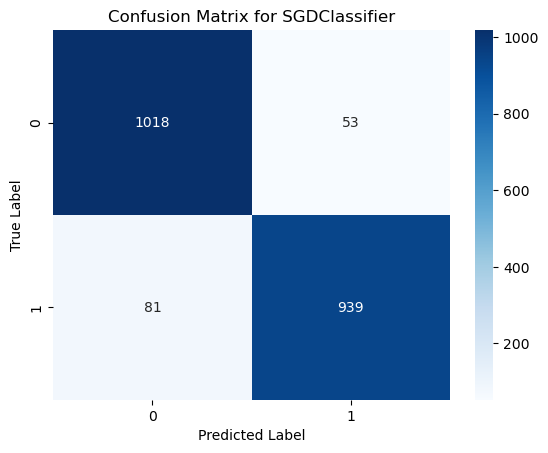


Classifier: LinearSVC
CV Accuracy Mean: 92.53% ± 0.96%
Test Accuracy: 93.26%
Test Precision: 93.29%
Test Recall: 93.26%
Test F1-Score: 93.25%

The LinearSVC classifier achieves a test accuracy of 93.26%, indicating its overall performance.
Precision of 93.29% suggests how often the classifier's positive predictions are correct.
Recall of 93.26% shows how well the classifier captures all relevant positives in the dataset.
The F1-Score, a weighted average of precision and recall, is 93.25%, balancing both false positives and false negatives.

These metrics help in deciding the most effective model for fake news detection.

Classifier: LogisticRegression
CV Accuracy Mean: 90.95% ± 1.27%
Test Accuracy: 91.44%
Test Precision: 91.54%
Test Recall: 91.44%
Test F1-Score: 91.43%

The LogisticRegression classifier achieves a test accuracy of 91.44%, indicating its overall performance.
Precision of 91.54% suggests how often the classifier's positive predictions are correct.
Recall of 91.44% shows

In [62]:
# Save confusion matrix as heatmap
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix for {best_classifier}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Save classification report
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report.to_csv("classification_report.csv")

# Discussion on the results
for name, metrics in results.items():
    print(f"\nClassifier: {name}")
    print(f"CV Accuracy Mean: {metrics['CV Accuracy Mean (%)']:.2f}% ± {metrics['CV Accuracy Std (%)']:.2f}%")
    print(f"Test Accuracy: {metrics['Test Accuracy (%)']:.2f}%")
    print(f"Test Precision: {metrics['Test Precision (%)']:.2f}%")
    print(f"Test Recall: {metrics['Test Recall (%)']:.2f}%")
    print(f"Test F1-Score: {metrics['Test F1-Score (%)']:.2f}%")

    # Explanation of results
    print(f"\nThe {name} classifier achieves a test accuracy of {metrics['Test Accuracy (%)']:.2f}%, indicating its overall performance.")
    print(f"Precision of {metrics['Test Precision (%)']:.2f}% suggests how often the classifier's positive predictions are correct.")
    print(f"Recall of {metrics['Test Recall (%)']:.2f}% shows how well the classifier captures all relevant positives in the dataset.")
    print(f"The F1-Score, a weighted average of precision and recall, is {metrics['Test F1-Score (%)']:.2f}%, balancing both false positives and false negatives.")

    print("\nThese metrics help in deciding the most effective model for fake news detection.")

# Highlight the superior performance of the best classifier
print(f"\n{best_classifier} gives the best test accuracy of {best_accuracy:.2f}%.")

print(f"\nOverall, the {best_classifier} performs well, possibly due to its ability to handle large-scale and sparse data effectively, which is common in text classification tasks like fake news detection.")